In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  %load_ext autoreload
  %autoreload 2
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github


  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html
    
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/keyword_spotting
dataset/  main.py   models/     __pycache__/  utilsFunc.py
.git/     metrics/  notebooks/  README.md
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 1.3 MB/s eta 0:16:42tcmalloc: large alloc 1147494400 bytes == 0x3981c000 @  0x7f36865ec615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████▉                | 1055.7 MB 1.2 MB/s eta 0:14:41tcmalloc: large alloc 1434370048 bytes == 0x7de72000 @  0x7f

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.spectrogram_model import spectrogram_model
from utilsFunc import *
import numpy as np

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

In [ ]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

Using cuda


## Downloading and setting up the dataset

In [ ]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    if 'train_set' not in locals():  
        train_set = SubsetSC("training",root)
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = train_set[0]

# TODO : We are doing it without resampling it.
#resample_transform=torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

training & test sets finished in  0:01:54.062427


## Let's visualize the data !

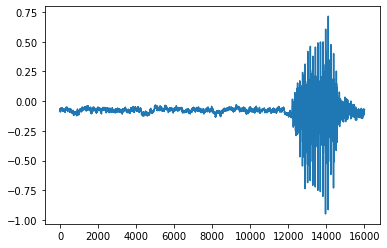

In [ ]:
plt.plot(storage['waveform'].t().numpy())

(241, 98)


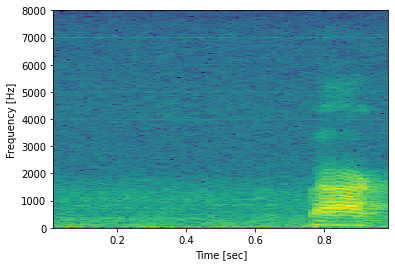

In [ ]:
from scipy import signal
from scipy.fft import fftshift

fe=16000
noverlap=int(20e-3*fe)
nperseg=int(30e-3*fe)
f, t, Sxx = signal.spectrogram(storage['waveform'][0], fe,noverlap=noverlap,nperseg=nperseg)
Sxx=20*np.log10(Sxx)
plt.pcolormesh(t, f, Sxx)
print(Sxx.shape)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:

n_mels=40

win_length=int(30e-3 *fe)
hop_length=int(10e-3 *fe)
n_fft=win_length # Permet d'augmenter le nombre d'échantillon de l'axe fréquentielle

y_min,x_min=0,0
y_max=fe/2
x_max=1

spec_size=(fe -win_length)/hop_length +1
print('size of tensor should be ',spec_size)

size of tensor should be  98.0


### Spectrogram transform

Shape of spectrogram: torch.Size([1, 241, 101])


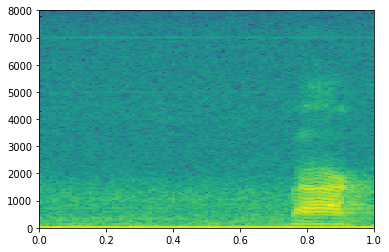

In [ ]:
spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft,win_length=win_length,hop_length=hop_length)

spectrogram=spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram.size()))

plt.figure()
plt.imshow(spectrogram.log2()[0].numpy(),interpolation='nearest', aspect='auto', origin='lower',extent=(x_min, x_max, y_min, y_max))

### Mel's spectrogram

Shape of spectrogram: torch.Size([1, 40, 101])


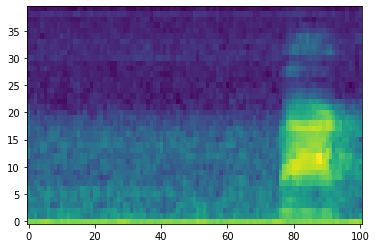

In [ ]:
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,
                                        n_mels=n_mels,win_length=win_length,hop_length=hop_length)
spectrogram_spec=mel_spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram_spec.size()))

# TODO : étiquetter l'axe des fréquences

plt.figure()
p = plt.imshow(spectrogram_spec.log2()[0].detach().numpy(),interpolation='nearest', aspect='auto', origin='lower')

### MFCC

Shape of spectrogram: torch.Size([1, 40, 101])


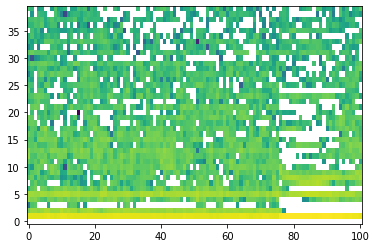

In [ ]:
MFCC_transform = torchaudio.transforms.MFCC(melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    })
MFCC_spec=MFCC_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(MFCC_spec.size()))

plt.figure()
p = plt.imshow(MFCC_spec.log2()[0].detach().numpy(),interpolation='nearest', aspect='auto', origin='lower')

### MuLaw encoding

Shape of transformed waveform: torch.Size([1, 16000])


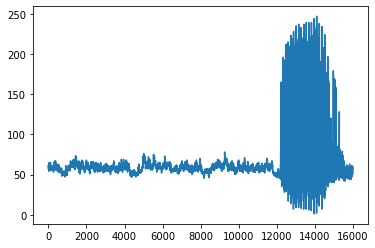

In [ ]:
MuLaw_transform=torchaudio.transforms.MuLawEncoding()
muLawEncoding=MuLaw_transform(storage['waveform'])
print("Shape of transformed waveform: {}".format(muLawEncoding.size()))

plt.figure()
plt.plot(muLawEncoding[0,:].numpy())

Shape of recovered waveform: torch.Size([1, 16000])


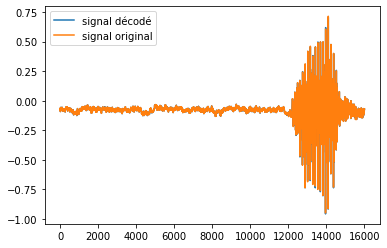

In [ ]:
reconstructed = torchaudio.transforms.MuLawDecoding()(muLawEncoding)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy(),label='signal décodé')
plt.plot(storage['waveform'].t().numpy(),label='signal original')
plt.legend()